Confirmed by omar

In [28]:
import cuml
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

In [29]:
import kagglehub


path = kagglehub.dataset_download("meirnizri/covid19-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-dataset


In [20]:
import os
print(os.listdir("/kaggle/input/covid19-dataset"))


['Covid Data.csv']


In [22]:
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [30]:
import cudf

path = "/kaggle/input/covid19-dataset/Covid Data.csv"
df = cudf.read_csv(path)


print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("Columns:", df.columns.tolist())


Number of rows: 1048575
Number of columns: 21
Columns: ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU']


In [31]:
df["IS_DEAD"] = df["DATE_DIED"].apply(lambda x: 0 if x == "9999-99-99" else 1)


In [32]:
columns_to_drop = ["DATE_DIED", "INTUBED" , "MEDICAL_UNIT"]

df = df.drop(columns=columns_to_drop)


In [35]:
df_dead = df[df["IS_DEAD"] == 1]
df_alive = df[df["IS_DEAD"] == 0]


df_dead_oversampled = df_dead.sample(n=len(df_alive), replace=True, random_state=42)
df_balanced = cudf.concat([df_alive, df_dead_oversampled])


In [36]:
X = df_balanced.drop(columns=["IS_DEAD"])
y = df_balanced["IS_DEAD"]

In [37]:
categorical_columns = ["SEX", "PREGNANT", "DIABETES", "COPD", "ASTHMA",
                       "INMSUPR", "HIPERTENSION", "OTHER_DISEASE",
                       "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]

X = cudf.get_dummies(X, columns=categorical_columns)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [47]:
X_test.to_pandas().to_csv("X_test.csv", index=False)
y_test.to_pandas().to_csv("y_test.csv", index=False)


In [39]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
import joblib

joblib.dump(model, "model.joblib")

['model.joblib']

In [ ]:
for col in X.columns:
    if X[col].dtype == "object":
        X = X.drop(columns=[col])
for col in X.columns:
    X[col] = X[col].astype("float32")
y = y.astype("int32")

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


RandomForestClassifier()

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)


KNeighborsClassifier()

In [40]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.8941214680671692


In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.to_pandas(), y_pred.to_pandas())
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[171748  22407]
 [ 18743 175755]]


In [42]:
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train.to_pandas(), y_train_pred.to_pandas())
print("Train Accuracy:", train_acc)


Train Accuracy: 0.8938410878181458


In [43]:
test_acc = accuracy_score(y_test.to_pandas(), y_pred.to_pandas())
print("Test Accuracy:", test_acc)

print("Variance Gap (Train - Test):", train_acc - test_acc)


Test Accuracy: 0.8941214680671692
Variance Gap (Train - Test): -0.0002803802490234375


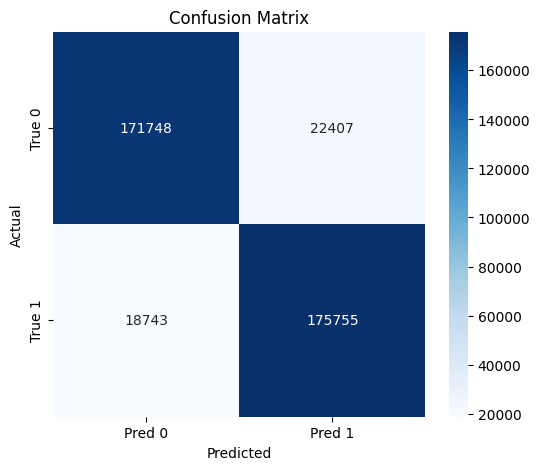

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test.to_pandas(), y_pred.to_pandas())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true = y_test.to_pandas()
y_predicted = y_pred.to_pandas()

print("Precision:", precision_score(y_true, y_predicted))
print("Recall:", recall_score(y_true, y_predicted))
print("F1 Score:", f1_score(y_true, y_predicted))
print("Accuracy:", accuracy_score(y_true, y_predicted))


Precision: 0.8869258485481576
Recall: 0.90363397052926
F1 Score: 0.8952019558905924
Accuracy: 0.8941214914075023


In [49]:
import joblib
import pandas as pd


model = joblib.load("model.joblib")


X_test = pd.read_csv("X_test.csv")


predictions = model.predict(X_test)


pd.DataFrame(predictions, columns=["IS_DEAD_PREDICTION"]).to_csv("predictions.csv", index=False)


print("Sample Predictions:")
print(predictions[:10])


Sample Predictions:
0    1
1    1
2    0
3    0
4    0
5    1
6    1
7    0
8    1
9    1
dtype: int64
